# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
labels = pd.read_csv(r'C:\Users\Mark\Desktop\appareal\labels.csv')
print('Всего значений: ', len(labels))
print()
print('Распределение возрастов:')
fig = px.histogram(labels, x="real_age")
fig.show()
print()
print(labels.real_age.describe())
print()
print('Уникальных значений: ', len(labels.real_age.unique()))
print()

Всего значений:  7591

Распределение возрастов:



count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Уникальных значений:  97



Видим, что данные целостные, нет необходимости в  предобработке, за исключением применения аргумента rescale при создании ImageDataGenerator.<br>
Всего у нас 97 уникальных значений<br>
Видим пики в значениях 1, 4, 16, 18, 25, 30, 40, 50, 60, 70, 80, 90. Возможно, что большинство фотографий сделаны "на юбилей" либо при перевыпуске документов. <br>
Если mae модели на валидационной выборке будет больше 17, можно сказать, что она не прошла проверку на адекватность.<br>
Размер датасета маленький, если не получится достичь целевой точности, используем аугментации.

In [6]:
idg=ImageDataGenerator(rescale=1./255.)
flow=idg.flow_from_dataframe(
    dataframe=labels, 
    directory=r'C:\Users\Mark\Desktop\appareal\final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    label_mode='int'
)

Found 7591 validated image filenames.


<Figure size 432x288 with 0 Axes>

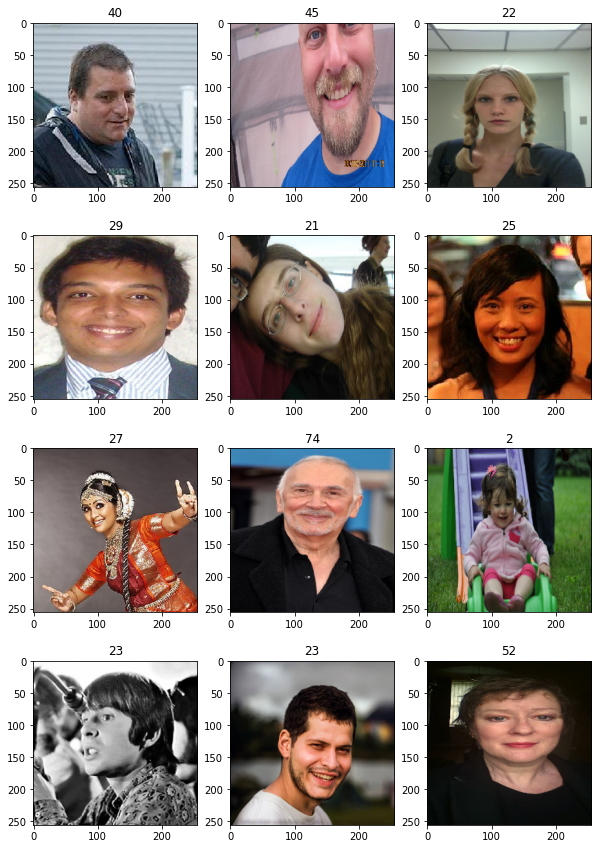

Размерность:  (256, 256, 3)


In [7]:
features, target = next(flow)
plt.figure()
fig, ax = plt.subplots(4,3, figsize=(10,15))
ax=ax.ravel()
for i in range(0,12):
    ax[i].imshow(features[i])
    ax[i].set_title(target[i])
plt.show()
    
print('Размерность: ', features[0].shape)

Изображения в данном датасете состоят из трех слоев размером 256*256.<br>
Интересно, что в датасете присутствуют как цветные, так и черно-белые изображения., некоторые из них обрезаны и повернуты, а некоторые  искажены, поэтому в случае использования аугментаций я бы стал использовать только зум (но есть опасность обрезать части лица) или horizontal_flip (наиболее приемлемый вариант). <br>
Большинство фотографий не сильно "зашумлены".<br>

Учитывая, что уникальных значений не так много, можно свести задачу от регрессии к классификации.<br>
Для того, чтобы добиться целевого  результата (mae <= 8) на валидационной выборке<br>
используем архитектуру ResNet50<br>

## Обучение модели

```python
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    directory = path + '/final_files'
    idg = ImageDataGenerator(validation_split=0.25)
    flow = idg.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        subset='training',
        shuffle=True,
        class_mode='raw'
    )
    return flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    directory = path + '/final_files'
    idg = ImageDataGenerator(validation_split=0.25)
    flow = idg.flow_from_dataframe(
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        class_mode='raw'
    )
    return flow


def create_model(input_shape):
    opt = tensorflow.optimizers.Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              validation_data=test_data,
              epochs=epochs,
              verbose=1,
              shuffle=True)
    return model
```

Train for 178 steps, validate for 60 steps<br>
Epoch 1/20
178/178 [==============================] - 53s 299ms/step - loss: 14.7597 - mae: 14.7582 - val_loss: 11.1166 - val_mae: 11.0706<br>
Epoch 2/20
178/178 [==============================] - 43s 243ms/step - loss: 7.2872 - mae: 7.2866 - val_loss: 7.1979 - val_mae: 7.1836<br>
Epoch 3/20
178/178 [==============================] - 44s 245ms/step - loss: 5.8079 - mae: 5.8074 - val_loss: 9.5290 - val_mae: 9.5094<br>
Epoch 4/20
178/178 [==============================] - 43s 242ms/step - loss: 4.9315 - mae: 4.9319 - val_loss: 9.0473 - val_mae: 9.0185<br>
Epoch 5/20
178/178 [==============================] - 43s 240ms/step - loss: 4.4762 - mae: 4.4766 - val_loss: 7.2362 - val_mae: 7.2153<br>
Epoch 6/20
178/178 [==============================] - 44s 245ms/step - loss: 4.0852 - mae: 4.0853 - val_loss: 6.4022 - val_mae: 6.3779<br>
Epoch 7/20
178/178 [==============================] - 43s 243ms/step - loss: 3.7294 - mae: 3.7296 - val_loss: 8.1672 - val_mae: 8.1290<br>
Epoch 8/20
178/178 [==============================] - 43s 242ms/step - loss: 3.4578 - mae: 3.4578 - val_loss: 6.2765 - val_mae: 6.2730<br>
Epoch 9/20
178/178 [==============================] - 43s 244ms/step - loss: 3.3497 - mae: 3.3499 - val_loss: 6.6453 - val_mae: 6.5994<br>
Epoch 10/20
178/178 [==============================] - 43s 242ms/step - loss: 3.0869 - mae: 3.0871 - val_loss: 6.9589 - val_mae: 6.9503<br>
Epoch 11/20
178/178 [==============================] - 43s 243ms/step - loss: 2.8957 - mae: 2.8959 - val_loss: 6.4256 - val_mae: 6.4134<br>
Epoch 12/20
178/178 [==============================] - 43s 243ms/step - loss: 2.6704 - mae: 2.6705 - val_loss: 6.8152 - val_mae: 6.8028<br>
Epoch 13/20
178/178 [==============================] - 43s 242ms/step - loss: 2.5316 - mae: 2.5317 - val_loss: 6.5978 - val_mae: 6.5751<br>
Epoch 14/20
178/178 [==============================] - 43s 242ms/step - loss: 2.3614 - mae: 2.3614 - val_loss: 6.2470 - val_mae: 6.2039<br>
Epoch 15/20
178/178 [==============================] - 43s 242ms/step - loss: 2.2632 - mae: 2.2633 - val_loss: 6.6100 - val_mae: 6.5759<br>
Epoch 16/20
178/178 [==============================] - 43s 244ms/step - loss: 2.1409 - mae: 2.1410 - val_loss: 6.1111 - val_mae: 6.0964<br>
Epoch 17/20
178/178 [==============================] - 44s 245ms/step - loss: 2.1545 - mae: 2.1546 - val_loss: 6.1061 - val_mae: 6.0778<br>
Epoch 18/20
178/178 [==============================] - 44s 246ms/step - loss: 2.0415 - mae: 2.0414 - val_loss: 6.3777 - val_mae: 6.3524<br>
Epoch 19/20
178/178 [==============================] - 44s 246ms/step - loss: 1.9990 - mae: 1.9990 - val_loss: 5.9118 - val_mae: 5.9110<br>
Epoch 20/20
178/178 [==============================] - 43s 244ms/step - loss: 1.9364 - mae: 1.9362 - val_loss: 5.8681 - val_mae: 5.8528<br>

Посмотрим, как повлияет на результат модели сокращение количества нейронов в выходном слое до 1го:

```python
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    directory = path + '/final_files'
    idg = ImageDataGenerator(validation_split=0.25)
    flow = idg.flow_from_dataframe(
        batch_size=16,
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        subset='training',
        shuffle=True,
        class_mode='raw'
    )
    return flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    directory = path + '/final_files'
    idg = ImageDataGenerator(validation_split=0.25)
    flow = idg.flow_from_dataframe(
        batch_size=16,
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        class_mode='raw'
    )
    return flow


def create_model(input_shape):
    opt = tensorflow.optimizers.Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              validation_data=test_data,
              epochs=epochs,
              verbose=1,
              shuffle=True)
    return model

model = create_model((256, 256, 3))
model.summary()
train_model(model, load_train(r'C:\Users\Mark\Desktop\appareal'), load_test(r'C:\Users\Mark\Desktop\appareal'))
```

Epoch 1/20 245/356 [===================>..........] - ETA: 38s - loss: 12.5134 - mae: 12.5134<br>
356/356 [==============================] - 144s 387ms/step - loss: 11.6482 - mae: 11.6482 - val_loss: 8.5939 - val_mae: 8.5939<br>
Epoch 2/20
356/356 [==============================] - 136s 383ms/step - loss: 8.2592 - mae: 8.2592 - val_loss: 10.0153 - val_mae: 10.0153<br>
Epoch 3/20
356/356 [==============================] - 137s 386ms/step - loss: 6.9008 - mae: 6.9008 - val_loss: 8.5481 - val_mae: 8.5481<br>
Epoch 4/20
356/356 [==============================] - 137s 384ms/step - loss: 6.0297 - mae: 6.0297 - val_loss: 7.8217 - val_mae: 7.8217<br>
Epoch 5/20
356/356 [==============================] - 135s 378ms/step - loss: 5.4140 - mae: 5.4140 - val_loss: 7.7258 - val_mae: 7.7258<br>
Epoch 6/20
356/356 [==============================] - 134s 377ms/step - loss: 5.0339 - mae: 5.0339 - val_loss: 7.4643 - val_mae: 7.4643<br>
Epoch 7/20
356/356 [==============================] - 134s 377ms/step - loss: 4.5654 - mae: 4.5654 - val_loss: 7.2519 - val_mae: 7.2519<br>
Epoch 8/20
356/356 [==============================] - 134s 376ms/step - loss: 4.3376 - mae: 4.3376 - val_loss: 7.5863 - val_mae: 7.5863<br>
Epoch 9/20
356/356 [==============================] - 134s 376ms/step - loss: 4.0057 - mae: 4.0057 - val_loss: 8.0038 - val_mae: 8.0038<br>
Epoch 10/20
356/356 [==============================] - 134s 376ms/step - loss: 3.8002 - mae: 3.8002 - val_loss: 6.8793 - val_mae: 6.8793<br>
Epoch 11/20
356/356 [==============================] - 134s 376ms/step - loss: 3.3984 - mae: 3.3984 - val_loss: 6.9189 - val_mae: 6.9189<br>
Epoch 12/20
356/356 [==============================] - 134s 375ms/step - loss: 3.2474 - mae: 3.2474 - val_loss: 7.4133 - val_mae: 7.4133<br>
Epoch 13/20
356/356 [==============================] - 134s 376ms/step - loss: 3.1521 - mae: 3.1521 - val_loss: 6.9789 - val_mae: 6.9789<br>
Epoch 14/20
356/356 [==============================] - 133s 374ms/step - loss: 2.9983 - mae: 2.9983 - val_loss: 6.9792 - val_mae: 6.9792<br>
Epoch 15/20
356/356 [==============================] - 134s 375ms/step - loss: 2.8943 - mae: 2.8943 - val_loss: 7.2534 - val_mae: 7.2534<br>
Epoch 16/20
356/356 [==============================] - 134s 377ms/step - loss: 2.8428 - mae: 2.8428 - val_loss: 7.1527 - val_mae: 7.1527<br>
Epoch 17/20
356/356 [==============================] - 134s 375ms/step - loss: 2.7066 - mae: 2.7066 - val_loss: 7.0398 - val_mae: 7.0398<br>
Epoch 18/20
356/356 [==============================] - 135s 378ms/step - loss: 2.6531 - mae: 2.6531 - val_loss: 7.3306 - val_mae: 7.3306<br>
Epoch 19/20
356/356 [==============================] - 135s 379ms/step - loss: 2.4825 - mae: 2.4825 - val_loss: 7.0355 - val_mae: 7.0355<br>
Epoch 20/20
356/356 [==============================] - 134s 377ms/step - loss: 2.3921 - mae: 2.3921 - val_loss: 6.9143 - val_mae: 6.9143<br>

Если использовать активацию relu на выходном слое: 
```python
def create_model(input_shape):
    opt = tensorflow.optimizers.Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=opt, loss='mae', metrics=['mae'])
    return model
```
Результат не улучшится:

Epoch 1/20 287/356 [=======================>......] - ETA: 23s - loss: 12.5443 - mae: 12.5443<br>
356/356 [==============================] - 141s 379ms/step - loss: 11.9427 - mae: 11.9427 - val_loss: 8.6938 - val_mae: 8.6938<br>
Epoch 2/20
356/356 [==============================] - 132s 371ms/step - loss: 8.0767 - mae: 8.0767 - val_loss: 9.8171 - val_mae: 9.8171<br>
Epoch 3/20
356/356 [==============================] - 132s 371ms/step - loss: 6.9942 - mae: 6.9942 - val_loss: 7.9129 - val_mae: 7.9129<br>
Epoch 4/20
356/356 [==============================] - 133s 374ms/step - loss: 6.0522 - mae: 6.0522 - val_loss: 8.0277 - val_mae: 8.0277<br>
Epoch 5/20
356/356 [==============================] - 137s 386ms/step - loss: 5.3481 - mae: 5.3481 - val_loss: 8.7876 - val_mae: 8.7876<br>
Epoch 6/20
356/356 [==============================] - 137s 385ms/step - loss: 4.9063 - mae: 4.9063 - val_loss: 7.5245 - val_mae: 7.5245<br>
Epoch 7/20
356/356 [==============================] - 136s 382ms/step - loss: 4.4253 - mae: 4.4253 - val_loss: 7.7594 - val_mae: 7.7594<br>
Epoch 8/20
356/356 [==============================] - 137s 383ms/step - loss: 4.1643 - mae: 4.1643 - val_loss: 7.7052 - val_mae: 7.7052<br>
Epoch 9/20
356/356 [==============================] - 137s 383ms/step - loss: 3.9560 - mae: 3.9560 - val_loss: 7.2868 - val_mae: 7.2868<br>
Epoch 10/20
356/356 [==============================] - 136s 383ms/step - loss: 3.7070 - mae: 3.7070 - val_loss: 7.2172 - val_mae: 7.2172<br>
Epoch 11/20
356/356 [==============================] - 136s 383ms/step - loss: 3.4339 - mae: 3.4339 - val_loss: 7.2042 - val_mae: 7.2042<br>
Epoch 12/20
356/356 [==============================] - 136s 383ms/step - loss: 3.3584 - mae: 3.3584 - val_loss: 7.6021 - val_mae: 7.6021<br>
Epoch 13/20
356/356 [==============================] - 136s 382ms/step - loss: 3.1847 - mae: 3.1847 - val_loss: 7.0169 - val_mae: 7.0169<br>
Epoch 14/20
356/356 [==============================] - 136s 383ms/step - loss: 2.9522 - mae: 2.9522 - val_loss: 7.1948 - val_mae: 7.1948<br>
Epoch 15/20
356/356 [==============================] - 136s 382ms/step - loss: 2.9610 - mae: 2.9610 - val_loss: 7.0164 - val_mae: 7.0164<br>
Epoch 16/20
356/356 [==============================] - 136s 383ms/step - loss: 2.7953 - mae: 2.7953 - val_loss: 7.2630 - val_mae: 7.2630<br>
Epoch 17/20
356/356 [==============================] - 136s 383ms/step - loss: 2.7601 - mae: 2.7601 - val_loss: 6.8796 - val_mae: 6.8796<br>
Epoch 18/20
356/356 [==============================] - 136s 383ms/step - loss: 2.5608 - mae: 2.5608 - val_loss: 7.4201 - val_mae: 7.4201<br>
Epoch 19/20
356/356 [==============================] - 136s 383ms/step - loss: 2.5369 - mae: 2.5369 - val_loss: 6.9522 - val_mae: 6.9522<br>
Epoch 20/20
356/356 [==============================] - 136s 383ms/step - loss: 2.4760 - mae: 2.4760 - val_loss: 7.0224 - val_mae: 7.0224<br>

## Анализ обученной модели

Обученная модель показала точность в  5.8528 mae на валидационной выборке, результат можно считать хорошим, учитывая, что mae все  ещё снижается  с каждой эпохой, можно сделать вывод, что можно получить ещё большую точность, если  увеличить время обучения. К сожалению, тренажер не поддерживает  EfficientNet модели,возможно их использование так-же помогло бы улучшить результат. Ещё один возможный способ улучшения результата -- использование аугментаций (в работе не  применялись).

После изменения модели (количество нейронов в выходном слое изменено с 128 на 1, активация relu теперь отсутствует), количество параметров уменьшилось на 260 223, а mae на валидационной выборке увеличилось на 1,0615. Однако, loss обучающей выборки ещё не так "исчерпан", как на первой итерации за те же 20 эпох,так что нельзя сделать однозначный вывод, какая модель будет более эффективной.